### Purpose

Test the WaveNet network on `pseudoGR` features. Demonstrate the difference between `categorical` loss, `ordinal` loss, and a combination.

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix

from coremdlr.viz import model_plots
from coremdlr.models import NetworkModel
from coremdlr.datasets import DepthSequenceGenerator, FaciesDataset


import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
well_names = ["205-21b-3", "204-20-6a", "204-24a-6", "204-20-1Z", "204-19-6"]

loss_options = ('categorical_crossentropy',
                'ordinal_squared_error',
                {'categorical_crossentropy': 0.2,
                 'ordinal_squared_error': 0.8})

wavenet_model_args = {
    'feature' : 'pseudoGR',
    'network' : 'wavenet',
    'sequence_size' : 128,
    'network_args' : {
        'num_blocks' : 20,
        'block_filters' : 128,
        'residual_filters' : 64,
        'output_resolution' : 32,
        'dropout_rate' : 0.5,
    },
    'optimizer_args' : {
        'optimizer' : 'Adam'
    }
}

fit_args = {
    'batch_size' : 16,
    'epochs' : 15,
    'class_weighted': True
}


In [3]:
for test_well in well_names:
    
    print(f'\n\nTESTING WITH TEST WELL: {test_well}\n\n')
    
    fdset = FaciesDataset([name for name in well_names if name != test_well],
                    test_wells=[test_well],
                    features=["pseudoGR"],
                    label_resolution=32, 
                    pseudoGR_args={'features': ['mean', 'var'], 
                                   'per_channel': True,
                                   'scaler' : 'robust'})

    fdset.load_or_generate_data()
    
    for loss in loss_options:
        
        print(f'\nMODELING WITH LOSS: {loss}\n')
        
        model_args = {**wavenet_model_args, **{'loss': loss}}
        
        wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)
    
        wavenet_model.fit(fdset, **fit_args)
        
        y_pred = wavenet_model.predict(fdset.X_test)

        cm = confusion_matrix(fdset.y_test, y_pred)
        
        fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(20,10))
        fig.suptitle(f'{test_well}: {loss}')

        model_plots.confusion_matrix_plot(cm, fdset.classes, ax=ax[0])
        model_plots.confusion_matrix_plot(cm, fdset.classes, ax=ax[1], normalize=True)
        
        plt.show()



TESTING WITH TEST WELL: 205-21b-3


Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:72: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:76: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


ValueError: b'os' is not in list

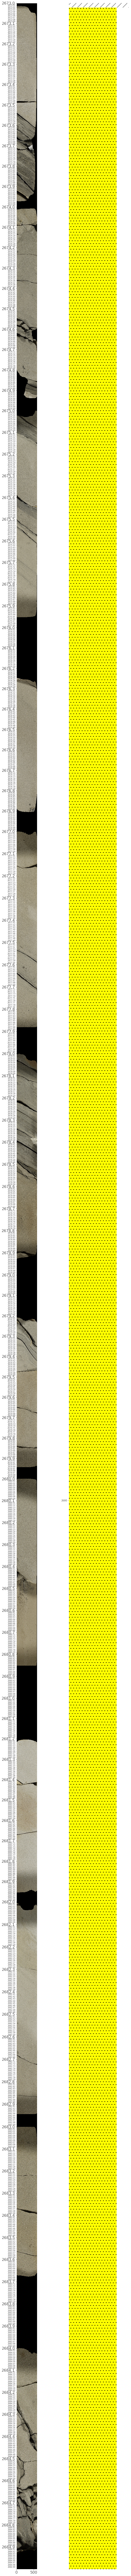

In [7]:
# What's up with this well -- all sand?
from coremdlr.viz import CorePlotter

fdset = Facies

well = fdset.get_well("204-20-1Z")

cplotter = CorePlotter(figsize=(10,200))
cplotter.plot_image(well._image / 255.0, depths=well._depth)

labels = well.make_striplog()
cplotter.plot_strip(labels)

plt.show()

## Categorical Loss

In [2]:
well_names = ["205-21b-3", "204-20-6a", "204-20-1Z", "204-19-6", "204-24a-6"]

fdset = FaciesDataset(well_names[:-1], [well_names[-1]], features=['pseudoGR'], label_resolution=32)

fdset.load_or_generate_data()

Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('pseudoGR', (3842, 32))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (3873,)), ('top', (3873,)), ('base', (3873,)), ('pseudoGR', (3873, 32))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('pseudoGR', (1884, 32))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('pseudoGR', (13006, 32))]


In [3]:
wavenet_model_args = {
    'feature' : 'pseudoGR',
    'network' : 'wavenet',
    'summary' : False,
    'sequence_size' : 128,
    'network_args' : {
        'num_blocks' : 20,
        'block_filters' : 128,
        'residual_filters' : 64,
        'output_resolution' : fdset.label_resolution,
        'dropout_rate' : 0.5,
    },
    'optimizer_args' : {
        'optimizer' : 'Adam',
    },
    'loss' : 'categorical_crossentropy'
}

fit_args = {
    'batch_size' : 32,
    'epochs' : 15,
    'step_size' : wavenet_model.sequence_size - 32
}



In [4]:
fit_args = {
    'batch_size' : 32,
    'epochs' : 15,
    'step_size' : wavenet_model.sequence_size - 32
}

wavenet_model.fit(fdset, **fit_args)

here 1
here 2
Shapes of `(batch_X, batch_y)`: (32, 4096), (32, 128, 4)
Epoch 1/15
4/4 [==============================] - 17s 4s/step - loss: 4.0121 - acc: 0.2374 - val_loss: 1.5847 - val_acc: 0.2989
Epoch 2/15
4/4 [==============================] - 4s 1s/step - loss: 1.3256 - acc: 0.2778 - val_loss: 1.3774 - val_acc: 0.2958
Epoch 3/15
4/4 [==============================] - 4s 1s/step - loss: 1.2260 - acc: 0.4007 - val_loss: 1.4497 - val_acc: 0.3185
Epoch 4/15
4/4 [==============================] - 4s 1s/step - loss: 1.1262 - acc: 0.4781 - val_loss: 1.5256 - val_acc: 0.2935
Epoch 5/15
4/4 [==============================] - 4s 1s/step - loss: 1.1178 - acc: 0.4855 - val_loss: 1.7021 - val_acc: 0.3205
Epoch 6/15
4/4 [==============================] - 4s 1s/step - loss: 1.1068 - acc: 0.5013 - val_loss: 1.4861 - val_acc: 0.2575
Epoch 7/15
4/4 [==============================] - 4s 1s/step - loss: 1.1001 - acc: 0.5066 - val_loss: 1.5806 - val_acc: 0.3081
Epoch 8/15
4/4 [=======================

1.364615811949113

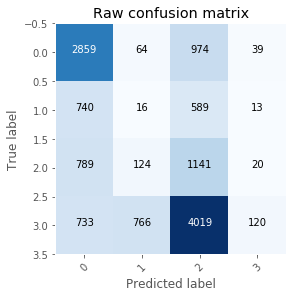

In [5]:
from sklearn.metrics import confusion_matrix

y_pred = wavenet_model.predict(fdset.X_test)

cm = confusion_matrix(fdset.y_test, y_pred)

model_plots.confusion_matrix_plot(cm, fdset.classes)

## Ordinal Loss

In [6]:
wavenet_model_args['loss'] = 'ordinal_squared_error'

wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)

wavenet_model.fit(fdset, **fit_args)

Shapes of `(batch_X, batch_y)`: (32, 4096), (32, 128, 4)
Epoch 1/15
4/4 [==============================] - 15s 4s/step - loss: 1.7321 - acc: 0.2377 - val_loss: 2.1522 - val_acc: 0.1086
Epoch 2/15
4/4 [==============================] - 4s 1s/step - loss: 1.1659 - acc: 0.2737 - val_loss: 1.8826 - val_acc: 0.1103
Epoch 3/15
4/4 [==============================] - 4s 1s/step - loss: 0.9399 - acc: 0.3167 - val_loss: 1.4949 - val_acc: 0.1479
Epoch 4/15
4/4 [==============================] - 4s 1s/step - loss: 0.8598 - acc: 0.3168 - val_loss: 1.3050 - val_acc: 0.1528
Epoch 5/15
4/4 [==============================] - 4s 1s/step - loss: 0.8054 - acc: 0.3339 - val_loss: 1.3663 - val_acc: 0.1533
Epoch 6/15
4/4 [==============================] - 4s 1s/step - loss: 0.7961 - acc: 0.3319 - val_loss: 1.3838 - val_acc: 0.1523
Epoch 7/15
4/4 [==============================] - 4s 1s/step - loss: 0.7616 - acc: 0.3335 - val_loss: 1.3796 - val_acc: 0.1563
Epoch 8/15
4/4 [==============================] - 4s 

1.3045707395265775

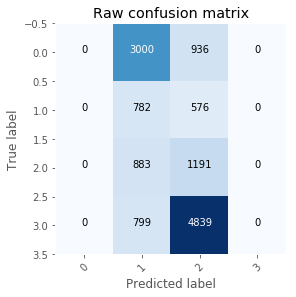

In [7]:
y_pred = wavenet_model.predict(fdset.X_test)

cm = confusion_matrix(fdset.y_test, y_pred)

model_plots.confusion_matrix_plot(cm, fdset.classes)

## Combined Loss

In [8]:
wavenet_model_args['loss'] = {'categorical_crossentropy': 0.15, 
                              'ordinal_squared_error' : 0.85}

wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)

In [9]:
wavenet_model.fit(fdset, **fit_args)

here 1
here 2
Shapes of `(batch_X, batch_y)`: (32, 4096), (32, 128, 4)
Epoch 1/15
4/4 [==============================] - 16s 4s/step - loss: 2.3566 - acc: 0.2562 - val_loss: 2.5296 - val_acc: 0.1086
Epoch 2/15
4/4 [==============================] - 4s 1s/step - loss: 1.2528 - acc: 0.2550 - val_loss: 1.6835 - val_acc: 0.3062
Epoch 3/15
4/4 [==============================] - 4s 1s/step - loss: 0.9287 - acc: 0.3414 - val_loss: 1.5673 - val_acc: 0.5845
Epoch 4/15
4/4 [==============================] - 4s 1s/step - loss: 0.8296 - acc: 0.4420 - val_loss: 1.6564 - val_acc: 0.3078
Epoch 5/15
4/4 [==============================] - 4s 1s/step - loss: 0.8086 - acc: 0.4906 - val_loss: 1.5276 - val_acc: 0.2826
Epoch 6/15
4/4 [==============================] - 4s 1s/step - loss: 0.7738 - acc: 0.4894 - val_loss: 1.5822 - val_acc: 0.3096
Epoch 7/15
4/4 [==============================] - 4s 1s/step - loss: 0.7741 - acc: 0.4554 - val_loss: 1.4034 - val_acc: 0.2447
Epoch 8/15
4/4 [=======================

1.3271017201520778

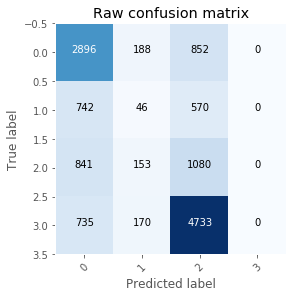

In [10]:
y_pred = wavenet_model.predict(fdset.X_test)

cm = confusion_matrix(fdset.y_test, y_pred)

model_plots.confusion_matrix_plot(cm, fdset.classes)

## Try same with class weighting

In [20]:
fit_args['class_weighted'] = True
fit_args['epochs'] = 9

wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)

wavenet_model.fit(fdset, **fit_args)

here 1
here 2
Shapes of `(batch_X, batch_y)`: (32, 4096), (32, 128, 4)
Epoch 1/9
4/4 [==============================] - 21s 5s/step - loss: 1.3692 - acc: 0.2569 - val_loss: 1.7527 - val_acc: 0.1086
Epoch 2/9
4/4 [==============================] - 5s 1s/step - loss: 0.8430 - acc: 0.2627 - val_loss: 1.3874 - val_acc: 0.1108
Epoch 3/9
4/4 [==============================] - 5s 1s/step - loss: 0.6668 - acc: 0.4149 - val_loss: 1.3284 - val_acc: 0.3166
Epoch 4/9
4/4 [==============================] - 5s 1s/step - loss: 0.6342 - acc: 0.4755 - val_loss: 1.2251 - val_acc: 0.2877
Epoch 5/9
4/4 [==============================] - 5s 1s/step - loss: 0.6084 - acc: 0.4630 - val_loss: 1.0920 - val_acc: 0.5148
Epoch 6/9
4/4 [==============================] - 5s 1s/step - loss: 0.6390 - acc: 0.4486 - val_loss: 1.2628 - val_acc: 0.2569
Epoch 7/9
4/4 [==============================] - 5s 1s/step - loss: 0.6209 - acc: 0.3951 - val_loss: 1.2749 - val_acc: 0.2964
Epoch 8/9
4/4 [==============================]

1.091979438011293

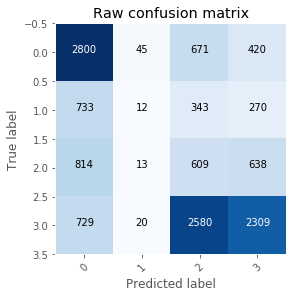

In [21]:
y_pred = wavenet_model.predict(fdset.X_test)

cm = confusion_matrix(fdset.y_test, y_pred)

model_plots.confusion_matrix_plot(cm, fdset.classes)

In [13]:
np.bincount(fdset.y_train) / fdset.y_train.size

array([0.28759986, 0.2451372 , 0.33475165, 0.13251129])

In [22]:
fit_args['class_weighted'] = True
fit_args['epochs'] = 30

wavenet_model = NetworkModel(fdset, model_args=wavenet_model_args)

wavenet_model.fit(fdset, **fit_args)

here 1
here 2
Shapes of `(batch_X, batch_y)`: (32, 4096), (32, 128, 4)
Epoch 1/30
4/4 [==============================] - 23s 6s/step - loss: 1.6039 - acc: 0.1957 - val_loss: 1.7008 - val_acc: 0.1086
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 0.8408 - acc: 0.2481 - val_loss: 1.2969 - val_acc: 0.1095
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 0.6670 - acc: 0.3901 - val_loss: 1.1923 - val_acc: 0.1484
Epoch 4/30
4/4 [==============================] - 5s 1s/step - loss: 0.6032 - acc: 0.4014 - val_loss: 1.3088 - val_acc: 0.2751
Epoch 5/30
4/4 [==============================] - 5s 1s/step - loss: 0.6213 - acc: 0.4638 - val_loss: 1.4025 - val_acc: 0.2867
Epoch 6/30
4/4 [==============================] - 5s 1s/step - loss: 0.6182 - acc: 0.4314 - val_loss: 1.1638 - val_acc: 0.1485
Epoch 7/30
4/4 [==============================] - 5s 1s/step - loss: 0.6025 - acc: 0.4453 - val_loss: 1.2229 - val_acc: 0.2925
Epoch 8/30
4/4 [=======================

1.0717799265903456